In [1]:
import tensorflow as tf
from tensorflow import keras

from keras import backend as K
from keras.models import Model
from keras.layers import Flatten, Dense, Dropout, Input
from keras.optimizers import Adam
from keras import layers, models
from keras.applications import DenseNet201
from keras.utils import image_dataset_from_directory
import numpy as np
from collections import Counter
from sklearn.utils import class_weight
import math
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint


In [2]:
class Distiller(tf.keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def get_config(self):
        config = super(Distiller, self).get_config()
        config.update({
            "student": self.student,
            "teacher": self.teacher
        })
        return config

    @classmethod
    def from_config(cls, config):
        student = config.pop("student")
        teacher = config.pop("teacher")
        return cls(student=student, teacher=teacher)

    def compile(
        self, optimizer, metrics, student_loss_fn, distillation_loss_fn, alpha=0.1, temperature=3
    ):
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        if len(data) == 3:
            x, y, sample_weight = data
        else:
            sample_weight = None
            x, y = data

        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            student_predictions = self.student(x, training=True)
            
            student_loss = self.student_loss_fn(
                y, 
                student_predictions,
                sample_weight=sample_weight
            )
            
            
            sparse_categorical_crossentropy = tf.keras.metrics.sparse_categorical_crossentropy(
                y, student_predictions
            )
            
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
                sample_weight=sample_weight
            ) * self.temperature**2

            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        gradients = tape.gradient(loss, self.student.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.student.trainable_variables))

        
        self.compiled_metrics.update_state(y, student_predictions, sample_weight=sample_weight)

        
        results = {m.name: m.result() for m in self.metrics}
        
       
        results.update({
            "student_loss": student_loss,
            "distillation_loss": distillation_loss,
            "sparse_categorical_crossentropy": tf.reduce_mean(sparse_categorical_crossentropy)
        })
        
        return results

    def test_step(self, data):
        if len(data) == 3:
            x, y, sample_weight = data
        else:
            sample_weight = None
            x, y = data

        student_predictions = self.student(x, training=False)
        
        student_loss = self.student_loss_fn(
            y, 
            student_predictions,
            sample_weight=sample_weight
        )
        
        
        sparse_categorical_crossentropy = tf.keras.metrics.sparse_categorical_crossentropy(
            y, student_predictions
        )

       
        self.compiled_metrics.update_state(y, student_predictions, sample_weight=sample_weight)

       
        results = {m.name: m.result() for m in self.metrics}
        
        
        results.update({
            "student_loss": student_loss,
            "sparse_categorical_crossentropy": tf.reduce_mean(sparse_categorical_crossentropy)
        })
            
        return results

    def call(self, inputs, training=None):
        return self.student(inputs, training=training)

In [3]:
import os
print("Directory exists:", os.path.exists(r'input/train_split'))
print("Directory contents:", os.listdir(r'input/train_split'))

img_gen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = img_gen.flow_from_directory(
    r'input/train_split',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    subset='training'
)

validation_generator = img_gen.flow_from_directory(
    r'input/train_split',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    subset='validation'
)




Directory exists: True
Directory contents: ['0', '1', '4', '3', '2']
Found 2931 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


In [4]:
# Calculate class weights
def get_class_distribution(generator):
    return Counter(generator.classes)

def compute_balanced_weights(class_counts):
    n_samples = sum(class_counts.values())
    n_classes = len(class_counts)
    smoothing_factor = 0.15
    weights = {
        cls: (n_samples / (n_classes * count)) * (1 - smoothing_factor) + (smoothing_factor * (n_samples / n_classes))
        for cls, count in class_counts.items()
    }
    total_weight = sum(weights.values())
    return {cls: weight / total_weight * n_classes for cls, weight in weights.items()}

class_counts = get_class_distribution(train_generator)
class_weight_dict = compute_balanced_weights(class_counts)


In [5]:
def get_class_distribution(generator):
    labels = generator.classes
    return Counter(labels)


def compute_balanced_weights(class_counts):
    n_samples = sum(class_counts.values())
    n_classes = len(class_counts)
    smoothing_factor = 0.01
    weights = {
        cls: (n_samples / (n_classes * count)) * (1 - smoothing_factor) + (smoothing_factor * (n_samples / n_classes))
        for cls, count in class_counts.items()
    }
    total_weight = sum(weights.values())
    weights = {cls: weight/total_weight * n_classes for cls, weight in weights.items()}
    return weights

# Calculate weights
class_counts = get_class_distribution(train_generator)
print("Class distribution:", class_counts)


balanced_weights = compute_balanced_weights(class_counts)
class_weight_dict = balanced_weights

class_weight_dict


Class distribution: Counter({0: 1444, 2: 800, 1: 296, 4: 236, 3: 155})


{0: 0.8113624824673042,
 1: 1.013261575269528,
 2: 0.8532688551440583,
 3: 1.244280249490636,
 4: 1.0778268376284745}

In [6]:
# Model setup
densenet201_base = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
densenet201_base.trainable = False

teacher = models.Sequential([
    densenet201_base,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(512, activation='relu'),
    layers.Dense(5, activation='softmax')
])

2024-12-11 00:47:43.778522: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2024-12-11 00:47:43.778544: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-12-11 00:47:43.778551: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-12-11 00:47:43.778573: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-11 00:47:43.778585: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
# Load DenseNet-201 model
densenet201_base = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
densenet201_base.trainable = False 

teacher = models.Sequential([
    densenet201_base,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(512, activation='relu'),
    layers.Dense(5, activation='softmax')
])


densenet121_base = keras.applications.DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
densenet121_base.trainable = True

# Create the student model
student = models.Sequential([
    densenet121_base,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.65),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dense(5, activation='softmax')
])
student.trainable = True
student.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d_2  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 batch_normalization (Batch  (None, 1024)              4096      
 Normalization)                                                  
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 dense_6 (Dense)             (None, 256)               262400    
                                                                 
 dense_7 (Dense)             (None, 5)                

In [8]:

class MaxMinMetricsTracker(tf.keras.callbacks.Callback): 
    def __init__(self):
        super(MaxMinMetricsTracker, self).__init__()
        self.max_accuracy = float('-inf')
        self.min_crossentropy = float('inf')
        self.max_val_accuracy = float('-inf')
        self.min_val_crossentropy = float('inf')
        self.min_student_loss = float('inf')
        self.min_distillation_loss = float('inf')
    
    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            raise ValueError("Logs cannot be None")
            
        
        required_metrics = [
            'accuracy',
            'sparse_categorical_crossentropy',
            'val_accuracy',
            'val_sparse_categorical_crossentropy',
            'student_loss',
            'distillation_loss'
        ]
        
        missing_metrics = [metric for metric in required_metrics if metric not in logs]
        if missing_metrics:
            raise ValueError(f"Missing required metrics: {missing_metrics}")
        
        
        if logs['accuracy'] > self.max_accuracy:
            self.max_accuracy = logs['accuracy']
        
        if logs['sparse_categorical_crossentropy'] < self.min_crossentropy:
            self.min_crossentropy = logs['sparse_categorical_crossentropy']
            
        if logs['val_accuracy'] > self.max_val_accuracy:
            self.max_val_accuracy = logs['val_accuracy']
            
        if logs['val_sparse_categorical_crossentropy'] < self.min_val_crossentropy:
            self.min_val_crossentropy = logs['val_sparse_categorical_crossentropy']
            
        if logs['student_loss'] < self.min_student_loss:
            self.min_student_loss = logs['student_loss']
            
        if logs['distillation_loss'] < self.min_distillation_loss:
            self.min_distillation_loss = logs['distillation_loss']
        
        
        print(f"\nEpoch {epoch + 1} - Best Metrics:")
        print(f"Max accuracy: {self.max_accuracy:.4f}")
        print(f"Min crossentropy: {self.min_crossentropy:.4f}")
        print(f"Max val_accuracy: {self.max_val_accuracy:.4f}")
        print(f"Min val_crossentropy: {self.min_val_crossentropy:.4f}")
        print(f"Min student_loss: {self.min_student_loss:.4f}")
        print(f"Min distillation_loss: {self.min_distillation_loss:.4f}")


callbacks = [

    ModelCheckpoint(
        filepath='best_model',
        monitor='val_sparse_categorical_crossentropy',
        save_best_only=True,
        mode='min',
        save_weights_only=False,
        verbose=1
    ),
    
    MaxMinMetricsTracker() 
]

In [9]:
distiller = Distiller(student=student, teacher=teacher)
distiller.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(
        learning_rate=1e-4,
        clipnorm=1.0,
        clipvalue=0.5 
    ),
    metrics=[
        tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy'),
        tf.keras.metrics.SparseCategoricalCrossentropy(name='sparse_categorical_crossentropy')
    ],
    student_loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    distillation_loss_fn=tf.keras.losses.KLDivergence(),
    alpha=0.5,
    temperature=4.0
)

max_min_tracker = MaxMinMetricsTracker()

history = distiller.fit(
    train_generator,
    epochs=25,
    validation_data=validation_generator,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

Epoch 1/25


2024-12-11 00:47:57.819988: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


92/92 [==============================] - ETA: 0s - accuracy: 0.5715 - sparse_categorical_crossentropy: 1.0969 - student_loss: 1.3196 - distillation_loss: 0.0567
Epoch 1: val_sparse_categorical_crossentropy improved from inf to 1.70480, saving model to best_model
INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets



Epoch 1 - Best Metrics:
Max accuracy: 0.5715
Min crossentropy: 1.0969
Max val_accuracy: 0.6101
Min val_crossentropy: 1.7048
Min student_loss: 1.0430
Min distillation_loss: 0.0584
92/92 [==============================] - 206s 2s/step - accuracy: 0.5715 - sparse_categorical_crossentropy: 1.0969 - student_loss: 1.3166 - distillation_loss: 0.0567 - val_accuracy: 0.6101 - val_sparse_categorical_crossentropy: 1.7048 - val_student_loss: 1.7048
Epoch 2/25
92/92 [==============================] - ETA: 0s - accuracy: 0.6878 - sparse_categorical_crossentropy: 0.8254 - student_loss: 0.8780 - distillation_loss: 0.0624
Epoch 2: val_sparse_categorical_crossentropy improved from 1.70480 to 0.71994, saving model to best_model
INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets



Epoch 2 - Best Metrics:
Max accuracy: 0.6878
Min crossentropy: 0.8254
Max val_accuracy: 0.6922
Min val_crossentropy: 0.7199
Min student_loss: 0.8400
Min distillation_loss: 0.0584
92/92 [==============================] - 205s 2s/step - accuracy: 0.6878 - sparse_categorical_crossentropy: 0.8254 - student_loss: 0.8776 - distillation_loss: 0.0624 - val_accuracy: 0.6922 - val_sparse_categorical_crossentropy: 0.7199 - val_student_loss: 0.7199
Epoch 3/25
92/92 [==============================] - ETA: 0s - accuracy: 0.7520 - sparse_categorical_crossentropy: 0.5902 - student_loss: 0.6972 - distillation_loss: 0.0638
Epoch 3: val_sparse_categorical_crossentropy did not improve from 0.71994

Epoch 3 - Best Metrics:
Max accuracy: 0.7520
Min crossentropy: 0.5902
Max val_accuracy: 0.7551
Min val_crossentropy: 0.7199
Min student_loss: 0.5617
Min distillation_loss: 0.0584
92/92 [==============================] - 178s 2s/step - accuracy: 0.7520 - sparse_categorical_crossentropy: 0.5902 - student_loss: 0

INFO:tensorflow:Assets written to: best_model/assets



Epoch 4 - Best Metrics:
Max accuracy: 0.7642
Min crossentropy: 0.5902
Max val_accuracy: 0.7551
Min val_crossentropy: 0.6148
Min student_loss: 0.5617
Min distillation_loss: 0.0584
92/92 [==============================] - 234s 3s/step - accuracy: 0.7642 - sparse_categorical_crossentropy: 0.6836 - student_loss: 0.6163 - distillation_loss: 0.0643 - val_accuracy: 0.7373 - val_sparse_categorical_crossentropy: 0.6148 - val_student_loss: 0.6148
Epoch 5/25
92/92 [==============================] - ETA: 0s - accuracy: 0.7881 - sparse_categorical_crossentropy: 0.3843 - student_loss: 0.5656 - distillation_loss: 0.0657
Epoch 5: val_sparse_categorical_crossentropy improved from 0.61478 to 0.51308, saving model to best_model
INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets



Epoch 5 - Best Metrics:
Max accuracy: 0.7881
Min crossentropy: 0.3843
Max val_accuracy: 0.7962
Min val_crossentropy: 0.5131
Min student_loss: 0.4018
Min distillation_loss: 0.0584
92/92 [==============================] - 226s 2s/step - accuracy: 0.7881 - sparse_categorical_crossentropy: 0.3843 - student_loss: 0.5639 - distillation_loss: 0.0657 - val_accuracy: 0.7962 - val_sparse_categorical_crossentropy: 0.5131 - val_student_loss: 0.5131
Epoch 6/25
92/92 [==============================] - ETA: 0s - accuracy: 0.7881 - sparse_categorical_crossentropy: 0.6180 - student_loss: 0.5512 - distillation_loss: 0.0643
Epoch 6: val_sparse_categorical_crossentropy did not improve from 0.51308

Epoch 6 - Best Metrics:
Max accuracy: 0.7881
Min crossentropy: 0.3843
Max val_accuracy: 0.8098
Min val_crossentropy: 0.5131
Min student_loss: 0.4018
Min distillation_loss: 0.0584
92/92 [==============================] - 188s 2s/step - accuracy: 0.7881 - sparse_categorical_crossentropy: 0.6180 - student_loss: 0

INFO:tensorflow:Assets written to: best_model/assets



Epoch 7 - Best Metrics:
Max accuracy: 0.8130
Min crossentropy: 0.3843
Max val_accuracy: 0.8098
Min val_crossentropy: 0.4429
Min student_loss: 0.3830
Min distillation_loss: 0.0584
92/92 [==============================] - 224s 2s/step - accuracy: 0.8130 - sparse_categorical_crossentropy: 0.4231 - student_loss: 0.5007 - distillation_loss: 0.0665 - val_accuracy: 0.7770 - val_sparse_categorical_crossentropy: 0.4429 - val_student_loss: 0.4429
Epoch 8/25
92/92 [==============================] - ETA: 0s - accuracy: 0.8120 - sparse_categorical_crossentropy: 0.8054 - student_loss: 0.4809 - distillation_loss: 0.0669
Epoch 8: val_sparse_categorical_crossentropy did not improve from 0.44292

Epoch 8 - Best Metrics:
Max accuracy: 0.8130
Min crossentropy: 0.3843
Max val_accuracy: 0.8098
Min val_crossentropy: 0.4429
Min student_loss: 0.3830
Min distillation_loss: 0.0584
92/92 [==============================] - 192s 2s/step - accuracy: 0.8120 - sparse_categorical_crossentropy: 0.8054 - student_loss: 0

INFO:tensorflow:Assets written to: best_model/assets



Epoch 12 - Best Metrics:
Max accuracy: 0.8444
Min crossentropy: 0.3657
Max val_accuracy: 0.8140
Min val_crossentropy: 0.2366
Min student_loss: 0.3830
Min distillation_loss: 0.0584
92/92 [==============================] - 221s 2s/step - accuracy: 0.8434 - sparse_categorical_crossentropy: 0.3657 - student_loss: 0.3942 - distillation_loss: 0.0693 - val_accuracy: 0.8140 - val_sparse_categorical_crossentropy: 0.2366 - val_student_loss: 0.2366
Epoch 13/25
92/92 [==============================] - ETA: 0s - accuracy: 0.8482 - sparse_categorical_crossentropy: 0.3443 - student_loss: 0.3843 - distillation_loss: 0.0709
Epoch 13: val_sparse_categorical_crossentropy did not improve from 0.23663

Epoch 13 - Best Metrics:
Max accuracy: 0.8482
Min crossentropy: 0.3443
Max val_accuracy: 0.8140
Min val_crossentropy: 0.2366
Min student_loss: 0.3490
Min distillation_loss: 0.0584
92/92 [==============================] - 191s 2s/step - accuracy: 0.8482 - sparse_categorical_crossentropy: 0.3443 - student_los

In [11]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import image

# Read the test CSV file
test_df = pd.read_csv('input/aptos2019-blindness-detection/test.csv')


print("CSV file structure:")
print(test_df.head())
print("\nColumns in CSV:", test_df.columns.tolist())

# Load the best model
best_model = tf.keras.models.load_model('best_model')


def load_and_preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array / 255.0


predictions = []
processed_files = []
test_dir = 'input/aptos2019-blindness-detection/test_images'

try:
    # Verify test directory exists
    if not os.path.exists(test_dir):
        raise ValueError(f"Test directory not found: {test_dir}")
    
    print(f"Processing images from: {test_dir}")
    

    for img_name in os.listdir(test_dir):
        if img_name.endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(test_dir, img_name)
            
            
            img_array = load_and_preprocess_image(img_path)
            
    
            pred = best_model.predict(img_array, verbose=0)
            predictions.append(pred[0])
            
        
            processed_files.append(os.path.splitext(img_name)[0])
    
    # Convert predictions to class labels
    predicted_classes = np.argmax(predictions, axis=1)
    
    # Create results DataFrame
    results_df = pd.DataFrame({
        'id_code': processed_files,
        'predicted_class': predicted_classes
    })
    
    
    results_df = results_df.set_index('id_code').reindex(test_df['id_code']).reset_index()
    
    print("\nPrediction Results:")
    print(results_df.head())
    
    # Save predictions to CSV
    results_df.to_csv('test_predictions.csv', index=False)
    
    
    print("\nDistribution of predictions:")
    print(pd.Series(predicted_classes).value_counts().sort_index())
    
    print(f"\nTotal images processed: {len(processed_files)}")

except Exception as e:
    print(f"An error occurred: {str(e)}")
    raise

CSV file structure:
        id_code
0  0005cfc8afb6
1  003f0afdcd15
2  006efc72b638
3  00836aaacf06
4  009245722fa4

Columns in CSV: ['id_code']
Processing images from: input/aptos2019-blindness-detection/test_images

Prediction Results:
        id_code  predicted_class
0  0005cfc8afb6                2
1  003f0afdcd15                2
2  006efc72b638                2
3  00836aaacf06                2
4  009245722fa4                2

Distribution of predictions:
0    745
1     11
2    918
3    233
4     21
Name: count, dtype: int64

Total images processed: 1928


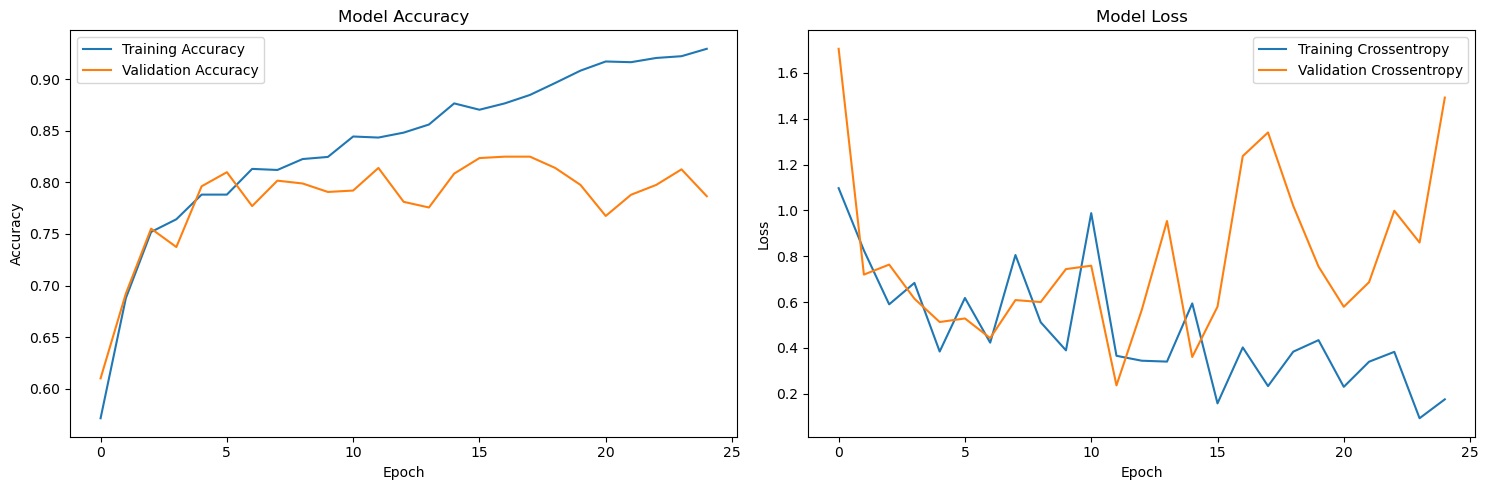

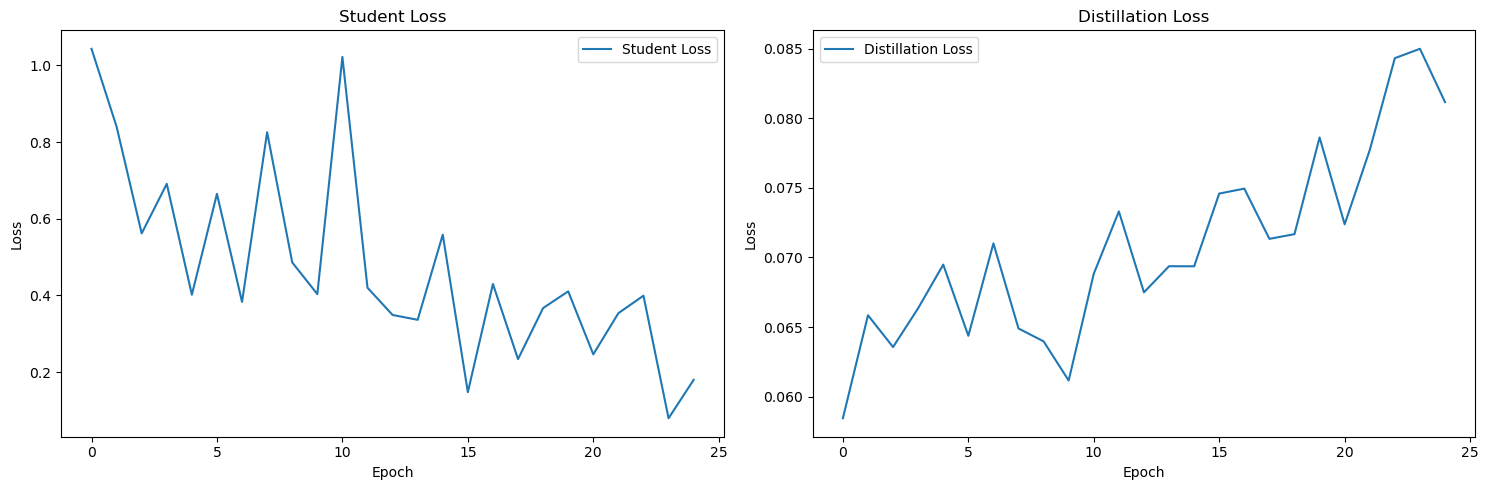


Best Training Metrics:
Best Training Accuracy: 0.9294
Best Validation Accuracy: 0.8249
Best Training Crossentropy: 0.0933
Best Validation Crossentropy: 0.2366
Best Student Loss: 0.0796
Best Distillation Loss: 0.0584


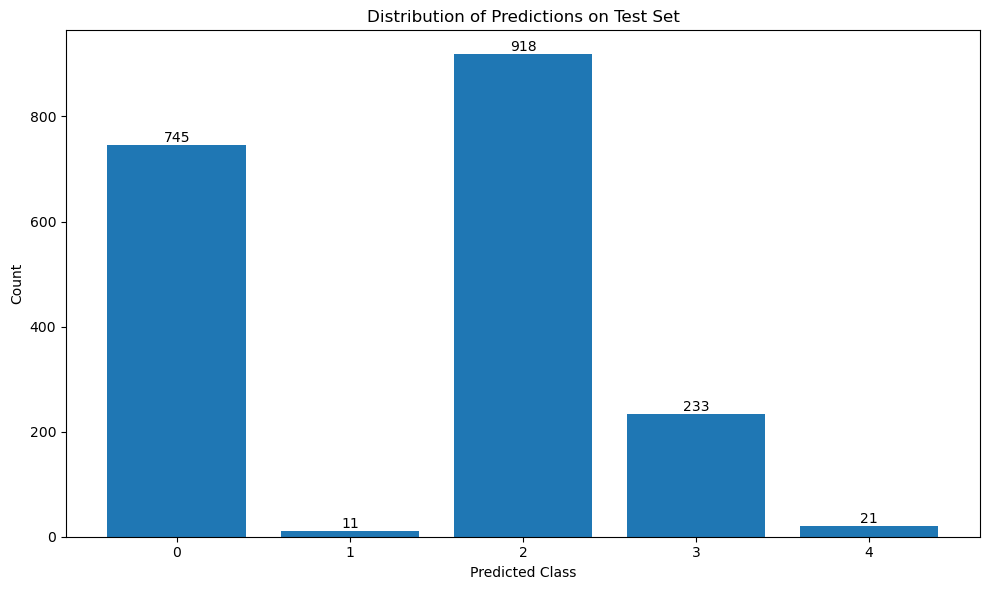

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


plt.figure(figsize=(15, 5))


plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss metrics
plt.subplot(1, 2, 2)
plt.plot(history.history['sparse_categorical_crossentropy'], label='Training Crossentropy')
plt.plot(history.history['val_sparse_categorical_crossentropy'], label='Validation Crossentropy')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 5))


plt.subplot(1, 2, 1)
plt.plot(history.history['student_loss'], label='Student Loss')
plt.title('Student Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history.history['distillation_loss'], label='Distillation Loss')
plt.title('Distillation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


print("\nBest Training Metrics:")
print(f"Best Training Accuracy: {max(history.history['accuracy']):.4f}")
print(f"Best Validation Accuracy: {max(history.history['val_accuracy']):.4f}")
print(f"Best Training Crossentropy: {min(history.history['sparse_categorical_crossentropy']):.4f}")
print(f"Best Validation Crossentropy: {min(history.history['val_sparse_categorical_crossentropy']):.4f}")
print(f"Best Student Loss: {min(history.history['student_loss']):.4f}")
print(f"Best Distillation Loss: {min(history.history['distillation_loss']):.4f}")

plt.figure(figsize=(10, 6))
pred_dist = pd.Series(predicted_classes).value_counts().sort_index()
plt.bar(range(len(pred_dist)), pred_dist.values)
plt.title('Distribution of Predictions on Test Set')
plt.xlabel('Predicted Class')
plt.ylabel('Count')
plt.xticks(range(len(pred_dist)))


for i, v in enumerate(pred_dist.values):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

23/23 [==============================] - 36s 1s/step


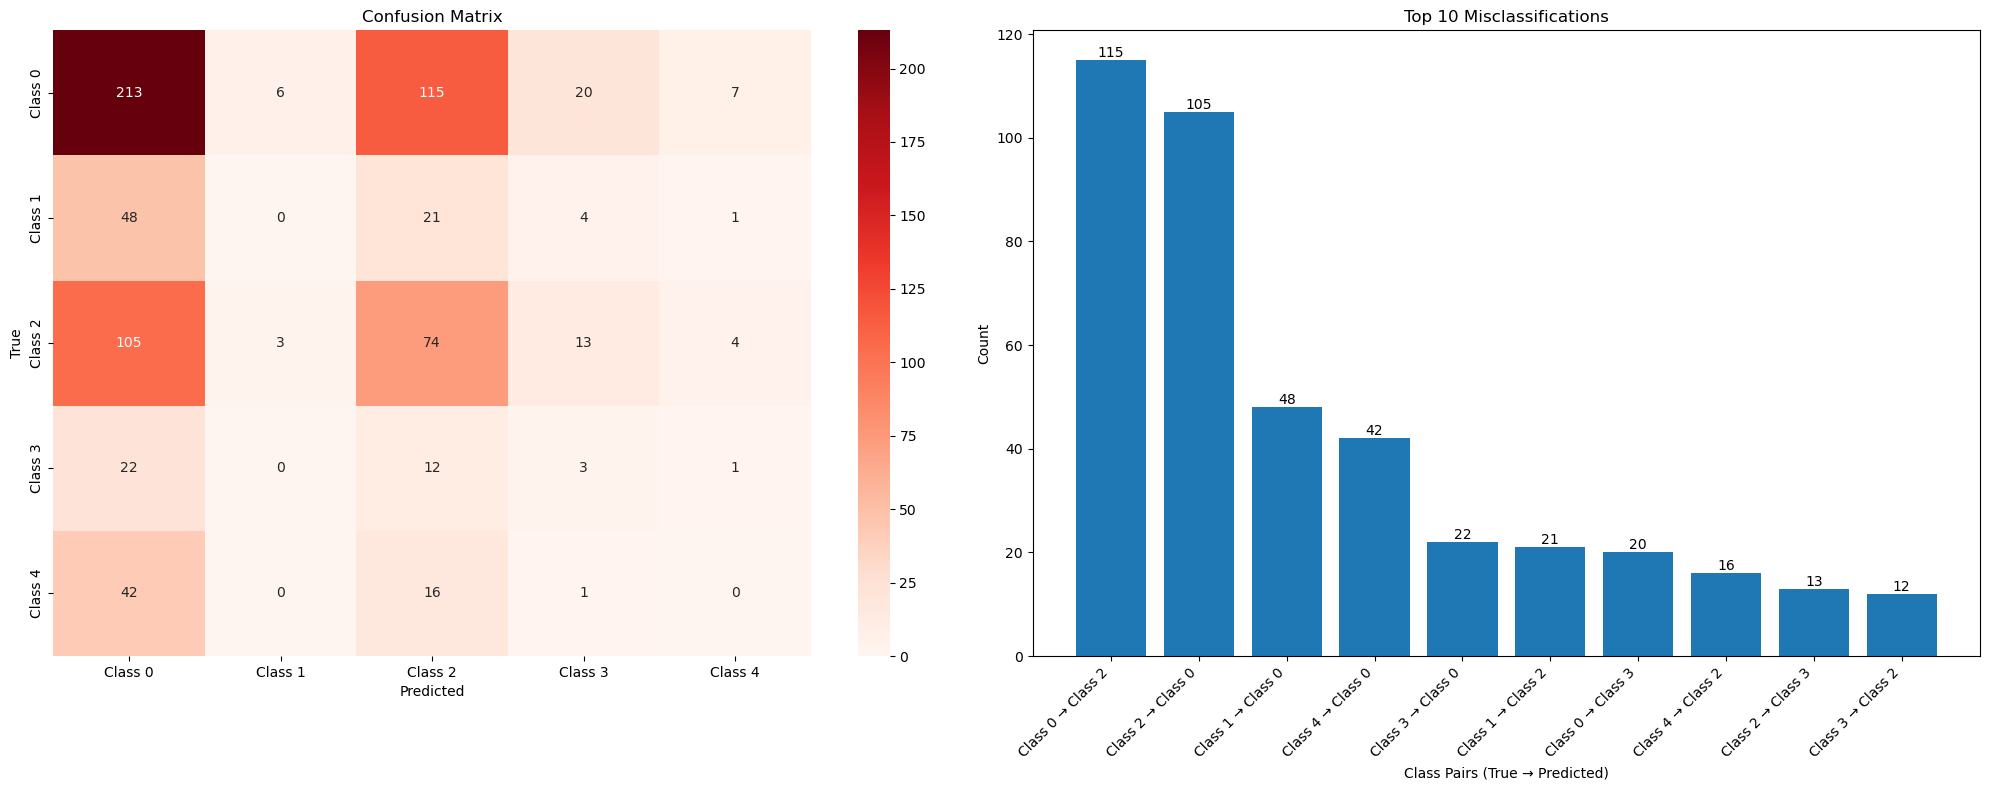

In [13]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, log_loss

# Get predictions for validation set
val_predictions = best_model.predict(validation_generator)
val_predicted_classes = np.argmax(val_predictions, axis=1)
val_true_classes = validation_generator.classes

cm = confusion_matrix(val_true_classes, val_predicted_classes)


plt.figure(figsize=(20, 8))


plt.subplot(1, 2, 1)
sns.heatmap(cm, 
            annot=True, 
            fmt='d', 
            cmap='Reds',
            xticklabels=['Class '+str(i) for i in range(5)],
            yticklabels=['Class '+str(i) for i in range(5)])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')


misclass_data = []
for true_class in range(5):
    for pred_class in range(5):
        if true_class != pred_class:
            count = cm[true_class][pred_class]
            if count > 0:
                misclass_data.append({
                    'True Class': f'Class {true_class}',
                    'Predicted Class': f'Class {pred_class}',
                    'Count': count,
                    'Percentage': (count / cm[true_class].sum()) * 100
                })

misclass_df = pd.DataFrame(misclass_data)
top_misclass = misclass_df.nlargest(10, 'Count')

plt.subplot(1, 2, 2)
bars = plt.bar(range(len(top_misclass)), top_misclass['Count'])
plt.xticks(range(len(top_misclass)), 
          [f"{row['True Class']} → {row['Predicted Class']}" 
           for _, row in top_misclass.iterrows()],
          rotation=45,
          ha='right')
plt.title('Top 10 Misclassifications')
plt.xlabel('Class Pairs (True → Predicted)')
plt.ylabel('Count')


for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

